### Importacion de Librerias

In [ ]:
import pandas as pd
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

### Obtener nuestros datos de stock:

In [ ]:
from pandas_datareader.yahoo.daily import YahooDailyReader
# Obtenga los datos de stock usando la API de Yahoo:
style.use('ggplot')

# obtener datos de 2014-2018 para entrenar nuestro modelo
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,30)
df = YahooDailyReader("AMZN", start, end).read()

# obtener datos de 2019 para probar nuestro modelo en
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = YahooDailyReader("AMZN", start, end).read()

### Arreglando nuestros datos:

In [ ]:
# ordenar por fecha
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-21,74.000000,68.197998,73.249496,68.872498,272806000,68.872498
2018-12-24,69.801498,65.349998,67.300003,67.197998,144400000,67.197998
2018-12-26,73.657997,68.150497,68.444504,73.544998,208236000,73.544998
2018-12-27,73.449997,69.515503,72.709999,73.082001,194440000,73.082001
2018-12-28,75.673500,72.449997,73.667503,73.901001,176580000,73.901001


#### Graficando nuestros datos y la media móvil:

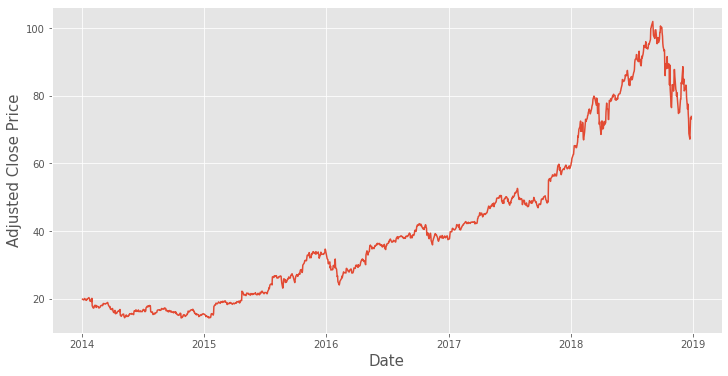

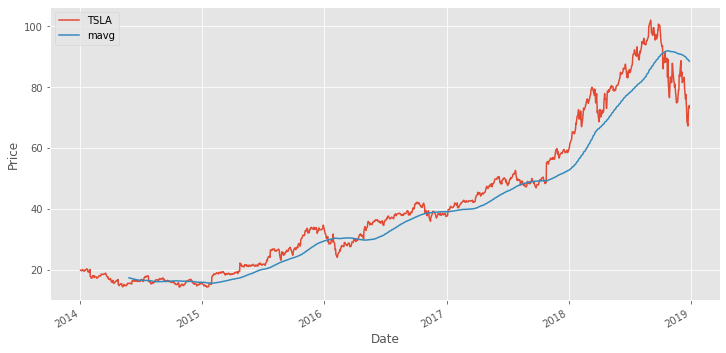

In [ ]:

# Visualice los datos del stock:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### Conversión de fechas:

In [ ]:
import matplotlib.dates as mdates

# cambiar las fechas en enteros para el entrenamiento
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Almacene las fechas originales para trazar las predicciones
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1252,737049.0,74.000000,68.197998,73.249496,68.872498,272806000,68.872498
1253,737052.0,69.801498,65.349998,67.300003,67.197998,144400000,67.197998
1254,737054.0,73.657997,68.150497,68.444504,73.544998,208236000,73.544998
1255,737055.0,73.449997,69.515503,72.709999,73.082001,194440000,73.082001
1256,737056.0,75.673500,72.449997,73.667503,73.901001,176580000,73.901001


### Normalizando nuestros datos:

In [ ]:
# Crear un conjunto de datos de entrenamiento de precios de 'Adj Close':
train_data = df.loc[:,'Adj Close'].to_numpy()
print(train_data.shape) # 1257 


# Aplique la normalización antes de alimentar a LSTM usando sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(1257,)


### Preparando nuestros datos para la red neuronal:

In [ ]:
'''Función para crear un conjunto de datos para alimentar un LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
    
# Cree los datos para entrenar nuestro modelo en:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# remodelarlo [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)


# Visualizando nuestros datos con impresiones:
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(1221, 36, 1)
X_train:
[[19.89850044]
 [19.8220005 ]
 [19.68149948]
 [19.9015007 ]
 [20.09600067]
 [20.05050087]
 [19.88299942]
 [19.54899979]
 [19.87700081]
 [19.7935009 ]
 [19.79000092]
 [19.98049927]
 [20.35250092]
 [20.22699928]
 [19.99349976]
 [19.37999916]
 [19.31399918]
 [19.7215004 ]
 [19.20999908]
 [20.15049934]
 [17.93449974]
 [17.30750084]
 [17.39749908]
 [17.32250023]
 [17.72949982]
 [18.05400085]
 [18.0435009 ]
 [18.08950043]
 [17.46249962]
 [17.86000061]
 [17.86750031]
 [17.68250084]
 [17.36899948]
 [17.48999977]
 [17.33799934]
 [17.5890007 ]]


y_train: [[17.91600037]]



### Aplicando modelo LTSM:

In [ ]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Construye el modelo
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(units = 1))

# Compilando el modelo
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Ajuste del modelo al conjunto de entrenamiento
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Epoch 1/20
86/86 [==============================] - 13s 86ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 2/20
86/86 [==============================] - 7s 78ms/step - loss: 5.1692e-04 - val_loss: 0.0021
Epoch 3/20
86/86 [==============================] - 4s 49ms/step - loss: 3.8458e-04 - val_loss: 0.0040
Epoch 4/20
86/86 [==============================] - 4s 49ms/step - loss: 3.2738e-04 - val_loss: 0.0026
Epoch 5/20
86/86 [==============================] - 4s 48ms/step - loss: 3.9698e-04 - val_loss: 0.0012
Epoch 6/20
86/86 [==============================] - 4s 48ms/step - loss: 2.8330e-04 - val_loss: 0.0023
Epoch 7/20
86/86 [==============================] - 4s 48ms/step - loss: 3.6624e-04 - val_loss: 0.0023
Epoch 8/20
86/86 [==============================] - 4s 48ms/step - loss: 3.2802e-04 - val_loss: 0.0014
Epoch 9/20
86/86 [==============================] - 4s 50ms/step - loss: 2.6885e-04 - val_loss: 0.0045
Epoch 10/20
86/86 [==============================] - 4s 48ms/step - loss: 2.

#### Grafica de la pérdida del modelo:

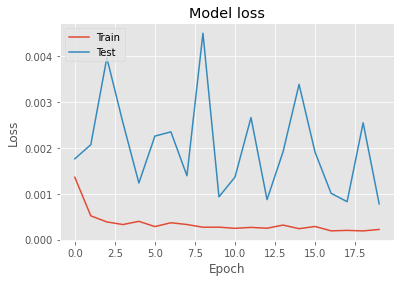

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Haciendo la predicción:

30/30 [==============================] - 2s 22ms/step


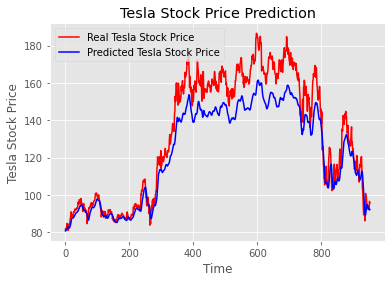

In [ ]:
# Obtenga los precios de las acciones para 2019 para que nuestro modelo haga las predicciones
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Cree los datos para probar nuestro modelo en:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# almacenar los valores originales para trazar las predicciones
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# remodelarlo [muestras, pasos de tiempo, características]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predecir los precios con el modelo.
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# Graficar los resultados 
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

### Conclusión: